In [23]:
from __future__ import division
import operator
import numpy as np
from numpy import sqrt, exp, absolute
import scipy.linalg as la
import scipy.optimize as so

# interactive plots
#%matplotlib notebook
# nice inline plots
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['text.usetex'] = True

# Exercise 1.1 Numerov for a Finite Harmonic Well

## Numerov's method and bound state preparation

### Plotting Helpers
These are just to reduce repetition in the code below.

In [2]:
def common_plt(title, xlabel, ylabel, fontsize=14, xlim=None, ylim=None,
               xone=True, yone=True, legend=True, legend_loc=None):
    plt.gcf().set_size_inches(10, 7)
    plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize, rotation='horizontal', ha='right')
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)
    if xone:
        plt.axvline(1, color='grey', linestyle='--')
    if yone:
        plt.axhline(1, color='grey', linestyle='--')
    if legend:
        plt.legend(loc=legend_loc)
    plt.show()

def common_plt_potential(*args):
    plt.gcf().set_size_inches(6, 5)
    plt.ylim(-1., .75)
    xs = np.linspace(0., 3., num=100)
    for pot in args:
        try:
            plt.plot(xs, [pot(x) for x in xs])
        except TypeError:
            plt.plot(xs, [pot[0](x) for x in xs], pot[1])
    plt.show()

### Numerov's Method

The algorithm described in Section 3.1.1 of the Lecture Notes

In [3]:
def numerov_step(k0, k1, k2, psi0, psi1, dx):
    """Perform a single Numerov step to compute psi2, given psi0 and psi1."""
    dd = dx**2/12.
    c0 = (1 + dd * k0)
    c1 = 2 * (1 - 5 * dd * k1)
    c2 = (1 + dd * k2)
    return (c1 * psi1 - c0 * psi0) / c2

def numerov(k, psi0, psi1, x_min, x_max, n, right_to_left=False):
    """
    Compute psi = [psi0, psi1, ...] for k = k(x) via iterated Numerov
    steps according to the given discretization parameters.
    Option to perform integration from right to left.
    """
    dx = (x_max-x_min)/(n-1)
    if right_to_left:
        dx = -dx
        x_start = x_max
    else:
        x_start = x_min
    k0, k1 = k(x_start), k(x_start + dx)
    
    # if both starting values are real, the result will remain real
    use_complex = not (complex(psi0).imag == 0 and complex(psi1).imag == 0)
    psi = np.zeros(n, dtype=np.complex128 if use_complex else np.float128)
    
    psi[:2] = psi0, psi1

    for i in range(2, n):
        k2 = k(x_start + i * dx)
        psi[i] = numerov_step(k0, k1, k2, psi[i-2], psi[i-1], dx)
        k0, k1 = k1, k2

    if right_to_left:
        psi = psi[::-1]
    return psi

### Bisection

In [4]:
def bisect(func, val, limits, tol=1e-3, maxiter=1000, 
           lt_func=operator.lt, 
           compare_func=lambda res, val, tol: np.abs(res - val) < tol):

    """Perform a bisection to search for x in limits where func(x) ~= val. Returns x, func(x), num_iterations."""
    low, high = limits
    low_val = func(low)
    high_val = func(high)
    
    # switch the limits s.t. func(low) < func(high) if needed
    if lt_func(high_val, low_val):
        high, low = low, high
        high_val, low_val = low_val, high_val
        
    # check that the desired value is in the interval
    if (not lt_func(low_val, val)) or (not lt_func(val, high_val)):
        raise ValueError(
            'The desired value {v} is not in the interval [{l}, {h}]'.format(
                v=val, l=low_val, h=high_val
            )
        )
    # perform the bisection
    for it in range(maxiter):
        x = (low + high) / 2
        xval = func(x)
        # check if the convergence criterion is met
        if compare_func(xval, val, tol):
            break
        elif lt_func(xval, val):
            low = x
        else:
            high = x
    return x, xval, it + 1

### Count nodes

In [5]:
def count_nodes(psi):
    """Returns the number of nodes in psi."""
    nodes = 0
    for p1, p2 in zip(psi, psi[1:]):
        if p1 * p2 < 0:
            nodes += 1
    return nodes

### Potential

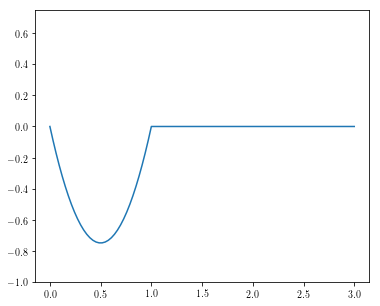

In [6]:
def trap_pot(c):
    """Return trap potential with minimum -0.25*c at x=0.5."""
    def V(x):
        if 0 < x < 1:
            return c*(x*x-x)
        return 0
    return V

common_plt_potential(trap_pot(c=3))


## One-sided integration
We attempt one-sided Numerov integration with bisection: if $\psi$ diverges, we have to refine our input energy.

In [7]:
xmax = 5
cV = 400
steps = int(xmax / 0.01)
dx = xmax / steps
xs = np.linspace(-dx, xmax, steps)

In [8]:
def shooting(E, cV=cV):
    """
    Apply Numerov for given energy.
    Return psi and the number of nodes.
    """
    k = lambda x: 2*(E - trap_pot(c=cV)(x))
    psi0 = exp(-sqrt(-2 * E) * dx)
    psi1 = 1.
    psi = numerov(k, psi0, psi1, 0, xmax, steps)
    return psi, count_nodes(psi)

### Number of bound states

The number of bound states can be calculated from the number of nodes at zero energy.

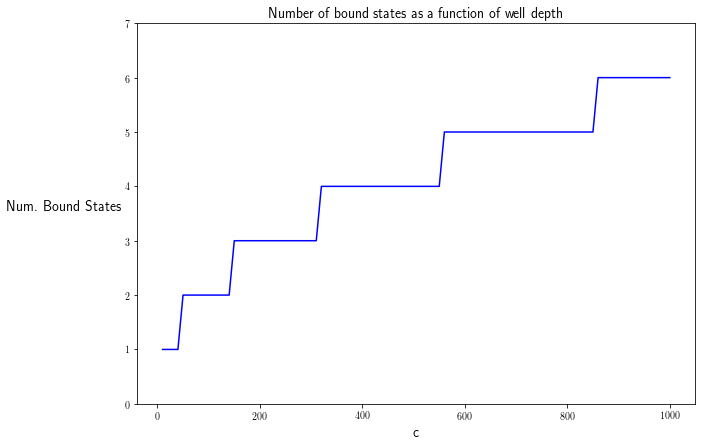

In [9]:
def get_num_bound(cV):
    psi, nodes = shooting(0, cV=cV)
    return nodes

def plot_num_bound(bound_fct):
    cvalues = np.linspace(10,1000,100)
    boundstates = [bound_fct(cV=cV) for cV in cvalues]

    plt.plot(cvalues,boundstates,'b')
    common_plt(title='Number of bound states as a function of well depth',
               xlabel='c', ylabel='Num. Bound States',
               ylim=[0,7], xone=False, yone=False, legend=False)

plot_num_bound(bound_fct=get_num_bound)

### Bound state solutions

We use bisection to get the bound state solutions. First we need to create comparison functions to plug into the bisection algorithm.

In [10]:
def lt_func(res1, res2):
    psi1, nodes1 = res1
    psi2, nodes2 = res2
    return nodes1 <= nodes2

def compare_func(res, val, tol):
    res_psi, res_nodes,  = res
    val_psi, val_nodes = val
    if res_nodes == val_nodes:
        return abs(res_psi[-1] - val_psi[-1]) < tol
    return False

Now we can create a function that gives the n-th bound state energy and wave function.

In [11]:
def get_bound_state(n, cV):
    E, (psi, nodes), it = bisect(func=shooting, val=([0], n), limits=(-cV, 0.), 
                                 tol=0.3, maxiter=500, 
                                 lt_func=lt_func, compare_func=compare_func)
    # We cut psi to get rid of the diverging tail
    psi = psi[:int(1 / dx) + 2]
    # normalize psi (this is not exactly right as we ignore the exponentially decaying tails)
    psi = psi / la.norm(psi)
    return E, psi

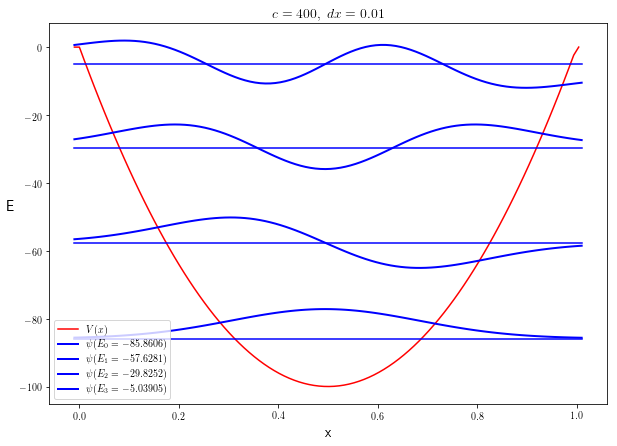

In [12]:
def plot_all_bound_states(num_bound_fct, get_bound_fct, cV, xs):
    pot = np.array([trap_pot(cV)(x) for x in xs])
    plt.plot(xs, pot, 'r', label='$V(x)$')

    for n in range(num_bound_fct(cV)):
        E, psi = get_bound_fct(n, cV)
        xs = np.linspace(-dx,1+dx,len(psi))
        plt.plot(xs, xs * 0 + E, 'b')
        plt.plot(xs, 50 * psi + E, 'b', label='$\psi(E_%d=%4g)$' % (n, E), linewidth=2)

    common_plt(title='$c={},\; dx={}$'.format(cV,dx),
               xlabel='x', ylabel='E',
               xone=False, yone=False)
    
plot_all_bound_states(get_num_bound, get_bound_state, cV=400, xs=xs[:int(1 / dx) + 2])

### Plotting the convergence

To see how the convergence algorithm behaves, we plot each trial psi during the bisection.

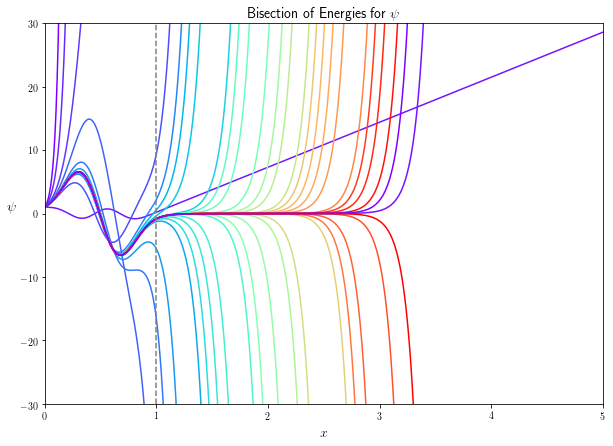

In [13]:
maxiter = 40
colors = cm.rainbow(np.linspace(0, 1, maxiter))
n = 1
cV = 400

def shooting_with_plot(E):
    psi, nodes = shooting(E)
    plt.plot(xs, psi, color=colors[shooting_with_plot.color % len(colors)])
    shooting_with_plot.color += 1
    return psi, nodes

shooting_with_plot.color = 0

bisect(func=shooting_with_plot, val=([0], n), limits=(-cV, 0.), tol=0.3, maxiter=maxiter, 
       lt_func=lt_func, compare_func=compare_func)

common_plt(
    title="Bisection of Energies for $\psi$",
    xlabel='$x$', ylabel='$\psi$',
    xlim=[0,xmax], ylim=[-30,30], yone=False, legend=False
)

We observe that the $\psi$ diverge abruptly. No matter how far we set $xmax$, it will at some point become unphysical.

## Bidirectional Matching

In [14]:
cV = 400
dx = 0.01
steps = int(1 / dx) + 2 
xs, dx = np.linspace(-dx, 1 + dx, steps, retstep=True)

In [15]:
def get_b_exact(E, cV=cV):
    """
    Returns b s.t. V(b) = E. Since we know the analytic form of V(x) we can just invert it. 
    """
    return 0.5 + sqrt(0.25 + E / cV)

# for an arbitrary potential we would have to use a root finder to get b.
def get_b_numerical(E, V=trap_pot(cV)):
    """
    Returns b s.t. V(b) = E.
    """
    return so.fsolve(lambda x: V(x) - E, 0.6)[0]

In [16]:
def shooting_bidirectional(E, cV=cV):
    """
    Performs the bidirectional shooting / matching algorithm.
    """
    # get the number of points on each side
    n_left = int(round(get_b_exact(E, cV=cV) / dx)) + 1
    n_right = len(xs) - n_left + 1 # the middle point needs to be included twice
    x_match = xs[n_left - 1]
    assert x_match == xs[-n_right]
    
    k = lambda x: 2*(E - trap_pot(c=cV)(x))
    psi0 = exp(-dx*sqrt(-2.*E))
    
     # k, psi0, psi1, x_min, x_max, n, right_to_left=False
    psi1 = numerov(k, psi0, 1, -dx, x_match, n_left)
    psi2 = numerov(k, psi0, 1, x_match, 1 + dx, n_right, right_to_left=True)
    
    dlogpsi1 = (psi1[-1] - psi1[-2]) / (dx * psi1[-1])
    dlogpsi2 = (psi2[1] - psi2[0]) / (dx * psi2[0])

    return (psi1, psi2), count_nodes(psi1) + count_nodes(psi2), dlogpsi2 - dlogpsi1

### Number of bound states

The number of bound states again can be calculated from the number of nodes at zero energy.

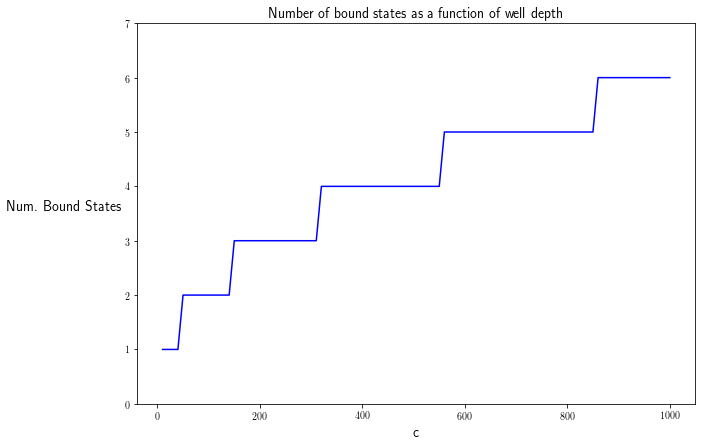

In [17]:
def get_num_bound_2(cV):
    _, nodes, dlogpsi_diff = shooting_bidirectional(0, cV=cV)
    # The state with n nodes is higher in energy (i.e., it doesn't exist).
    if dlogpsi_diff < 0:
        nodes -= 1
    return nodes + 1

plot_num_bound(bound_fct=get_num_bound_2)

### Bound state solutions
Again, we need to create comparison functions to plug into the bisection algorithm.

In [18]:
def lt_func_2(res1, res2):
    _, nodes1, logdiff1 = res1
    _, nodes2, logdiff2 = res2
    return (nodes1, logdiff1) < (nodes2, logdiff2)

def compare_func_2(res, val, tol):
    _, res_nodes, res_logdiff = res
    _, val_nodes, val_logdiff = val
    if res_nodes == val_nodes:
        return abs(res_logdiff - val_logdiff) < tol
    return False

In [19]:
def get_bound_state_2(n, cV):
    E, ((psi1, psi2), nodes, logdiff), it = bisect(
        func=shooting_bidirectional, val=([], n, 0), limits=(-cV / 4, 0.), tol=1e-6, maxiter=500, 
        lt_func=lt_func_2, compare_func=compare_func_2
    )
    
    # multiply psi2 such that it has the same value at x_match
    psi2 *= psi1[-1] / psi2[0]
    assert np.isclose(psi1[-1], psi2[0])
    # the matching point is in both psi1 and psi2
    psi = np.concatenate([psi1[:-1], psi2])
    # normalize psi (this is not exactly right -- we ignore the exponentially decaying tails)
    psi = psi / la.norm(psi)
    return E, psi

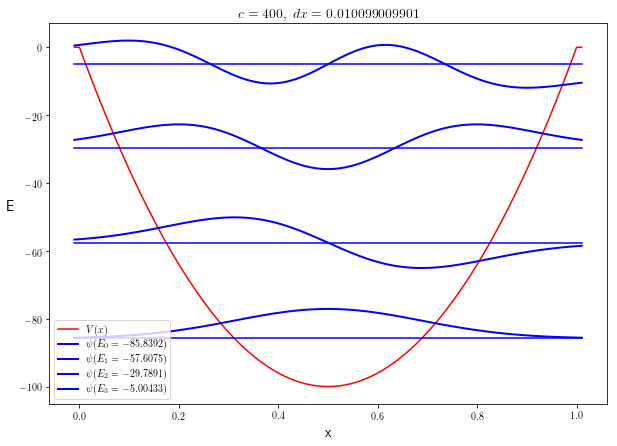

In [20]:
plot_all_bound_states(get_num_bound_2, get_bound_state_2, cV=400, xs=xs)

### Plotting the convergence

To see how the convergence algorithm behaves, we plot each trial psi during the bisection.

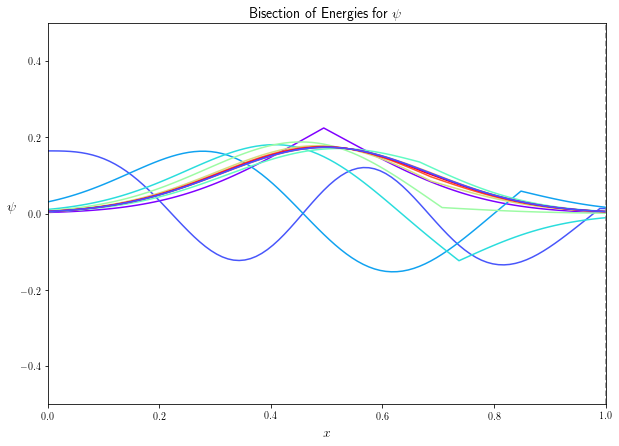

In [21]:
maxiter = 10
colors = cm.rainbow(np.linspace(0, 1, maxiter))
n = 0
cV = 400

def shooting_2_with_plot(E):
    (psi1, psi2), nodes, difflog = shooting_bidirectional(E)
    psi = np.concatenate([psi1[:-1], psi2 * psi1[-1] / psi2[0]])
    # normalize for better plotting
    psi /= la.norm(psi)
    plt.plot(xs, psi, color=colors[shooting_2_with_plot.color % len(colors)])
    shooting_2_with_plot.color += 1
    return (psi1, psi2), nodes, difflog

shooting_2_with_plot.color = 0

bisect(func=shooting_2_with_plot, val=([], n, 0), limits=(-cV / 4, 0.), tol=1e-6, maxiter=maxiter, 
       lt_func=lt_func_2, compare_func=compare_func_2)

common_plt(
    title="Bisection of Energies for $\psi$",
    xlabel='$x$', ylabel='$\psi$',
    xlim=[0,1], ylim=[-0.5, 0.5], yone=False, legend=False
)

$\psi_L$ and $\psi_R$ match where the diference $d\log\psi_R - d\log\psi_L$ is zero, which gives a nice visual indicator of the energies for our bound states.

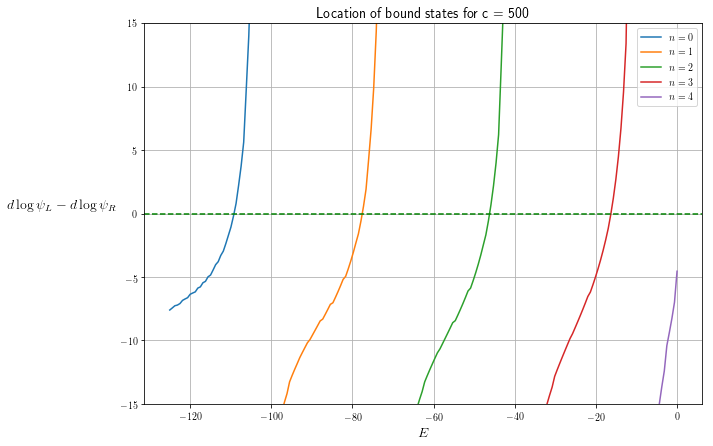

In [22]:
cV = 500
N = get_num_bound_2(cV)

energies = []
dlogdiff = []
currnodes = 0

for E in np.linspace(-cV / 4 + 1e-3, 0, 200):
    (_, nodes, diff) = shooting_bidirectional(E, cV=cV)
    if nodes == currnodes: # current curve (by node counter)
        energies.append(E)
        dlogdiff.append(diff)
    else: # start next curve
        plt.plot(energies, dlogdiff, label='$n={}$'.format(currnodes))
        energies = [E]
        dlogdiff = [diff]
        currnodes = nodes
        
plt.plot(energies, dlogdiff, label='$n={}$'.format(currnodes))
plt.grid()
plt.axhline(0,color='g',linestyle='--')

common_plt(
    title="Location of bound states for c = {}".format(cV),
    xlabel='$E$', ylabel='$d\\log \\psi_L - d\\log \\psi_R$',
    legend_loc='best',
    ylim=[-15, 15], xone=False, yone=False
)